In [53]:
import pandas as pd
import os
single_file_path = 'modified_single_version-ck-oo.csv'
changed_file_path = 'modified_change_metrics.csv'

def load_one_version_method_matrix(matrix_path):
    print(matrix_path)
    return pd.read_csv(matrix_path)
pd.read_csv("predicted_bugs.csv")

# a is th example of returned res['model'] from alamopy
a = '  z1 = 0.41321212602447952161322E-002 * x1 + 0.46806717586996456070825E-001 * x2 + 0.79645463805085067732215E-001 * x4 + 0.12307160368962345199650E-003 * x5 - 0.38964516723714214463045E-003 * x9 - 0.40535249039165190815259E-002 * x14 - 0.68930533922349646741567E-002 * x2*x4 + 0.68380218069032745655672E-003 * x4*x15 + 1.3010049545565156581262'
b = a.split(' + ')
split_list = []
for ai in b:
    if(ai!=ai.split(' - ')):
        ai = ai.split(' - ')
#         for one in ai:
#             print(one)
#             one = '-'+one
#             print(one)
    split_list += ai
split_list

['  z1 = 0.41321212602447952161322E-002 * x1',
 '0.46806717586996456070825E-001 * x2',
 '0.79645463805085067732215E-001 * x4',
 '0.12307160368962345199650E-003 * x5',
 '0.38964516723714214463045E-003 * x9',
 '0.40535249039165190815259E-002 * x14',
 '0.68930533922349646741567E-002 * x2*x4',
 '0.68380218069032745655672E-003 * x4*x15',
 '1.3010049545565156581262']

In [54]:
# put corfficient and variable in to a dict
c_v = {}
head = split_list[0]
tail = split_list[-1]
split_list[0] = head.split(' = ')[-1]
for one in split_list[0:-1]:
    coefficient = one.split(' * ')[0]
    variable = one.split(' * ')[1]
    
    c_v[coefficient] = variable
c_v,tail

({'0.41321212602447952161322E-002': 'x1',
  '0.46806717586996456070825E-001': 'x2',
  '0.79645463805085067732215E-001': 'x4',
  '0.12307160368962345199650E-003': 'x5',
  '0.38964516723714214463045E-003': 'x9',
  '0.40535249039165190815259E-002': 'x14',
  '0.68930533922349646741567E-002': 'x2*x4',
  '0.68380218069032745655672E-003': 'x4*x15'},
 '1.3010049545565156581262')

In [71]:
c_symobol = {}
for key in c_v.keys():
    #print(a.index(key))
    symbol = a[a.index(key)-2]
    #print(a[a.index(key)-2])
    if(symbol != "-"):
        c_symobol[key] = True
    else:
        c_symobol[key] = False
        
symbol = a[a.index(tail)-2]
if (symbol != '-'):
    c_symobol[tail] = True
else:
    c_symobol[tail] = False


# todo 
# add the sign to the dict

In [72]:
#load matrix and process it to adapt the res['model']

matrix = pd.read_csv("predicted_bugs.csv")
matrix.drop(matrix.columns[[0,1,2]],axis=1,inplace=True)
columnlen = len(matrix.columns.values)
for i in range(0,columnlen):
    matrix.rename(columns={ matrix.columns[i]: 'x'+str(i+1) }, inplace=True)
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 21 columns):
x1     162 non-null int64
x2     162 non-null int64
x3     162 non-null int64
x4     162 non-null int64
x5     162 non-null float64
x6     162 non-null float64
x7     162 non-null float64
x8     162 non-null float64
x9     162 non-null float64
x10    162 non-null float64
x11    162 non-null float64
x12    162 non-null float64
x13    162 non-null float64
x14    162 non-null float64
x15    162 non-null float64
x16    162 non-null int64
x17    162 non-null int64
x18    162 non-null int64
x19    162 non-null int64
x20    162 non-null int64
x21    162 non-null object
dtypes: float64(11), int64(9), object(1)
memory usage: 26.7+ KB


In [69]:
get_the_coff('0.41321212602447952161322E-002')

0.004132121260244795

In [76]:
#call alculcate_the_z_from_row to get the preidcted target of each row in the data set
import math
def get_the_coff(a):
    x1 = a.split('E')[0]
    x2 = a.split('E')[1]
    x2 = math.pow(10, int(x2))
    return x2*float(x1)

def calculcate_the_z_from_row(row):
    z = 0
    for key in c_v.keys():
        value = c_v[key]
        if(value.find('*')!=-1):# eg:x1*x14
            temp = 1.0
            keycof = get_the_coff(key)
            #print(keycof)
            temp = temp * keycof
            tempv = value.split('*')
            #print(tempv)
            for i in tempv:
                temp *= matrix[i][row]
            if(c_symobol[key]==True):
                #print(z)
                z += temp
            if(c_symobol[key]==False):
                #print(z)
                z-= temp
            
            
        else:
            temp2 = 1.0
            keycof = get_the_coff(key)
            temp2 = temp2*keycof
            temp2 *= matrix[value][row]
            
            if(c_symobol[key]==True):
                z += temp2
            if(c_symobol[key]==False):
                z -= temp2
    if(c_symobol[tail]==True):
        z = z + float(tail)
    else:
        z = z - float(tail)
    return z
    
calculcate_the_z_from_row(2)

2.223468200777072

In [75]:
def alamoresult():
    changed_buggy_matrix = pd.read_csv("predicted_bugs.csv")
    Y_target = changed_buggy_matrix['bugs'].values
    X_data = changed_buggy_matrix.values[:,3:18]
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x9 = []
    x14 = []
    x15 = []
    z1 = []
    for i, X_one in enumerate(X_data):
        x1 += [X_one[0]]
        x2+= [X_one[1]]
        x4+= [X_one[3]]
        x5+= [X_one[4]]
        x9+= [X_one[8]]
        x14+= [X_one[13]]
        x15+= [X_one[14]]
        z1 += [0.41321212602447952161322E-002 * x1[i-1] + 0.46806717586996456070825E-001 * x2[i-1] + 0.79645463805085067732215E-001 * x4[i-1] + 0.12307160368962345199650E-003 * x5[i-1] - 0.38964516723714214463045E-003 * x9[i-1] - 0.40535249039165190815259E-002 * x14[i-1] - 0.68930533922349646741567E-002 * x2[i-1]*x4[i-1] + 0.68380218069032745655672E-003 * x4[i-1]*x15[i-1] + 1.3010049545565156581262]
    
    return z1

Y_predict = alamoresult()

In [77]:
Y_trans_result = []
for i in range(0,162):
    Y_trans_result += [calculcate_the_z_from_row(i)]

In [85]:
def plot_the_predict_vs_data(predict_result):
    changed_buggy_matrix = pd.read_csv("predicted_bugs.csv")
    Y_target = changed_buggy_matrix['bugs'].values
    X_data = changed_buggy_matrix.values[:,3:18]
    x = np.arange(0, len(Y_predict),1)
    plt.plot(x,predict_result,label = "Predict_result")
    plt.plot(x,Y_target,label = "target")
    plt.legend()
    

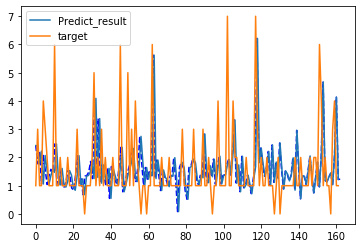

In [87]:
import numpy as np
import matplotlib.pyplot as plt
xline = np.linspace(0,162,162)
plt.plot(xline,Y_trans_result,'b--')
plot_the_predict_vs_data(Y_predict)

In [88]:
import alamopy

In [99]:
?alamopy.alamo